**What is Image Caption Generator?**

Image caption generator is a task that involves computer vision and natural language processing concepts to recognize the context of an image and describe them in a natural language like English.


**CNNs + RNNs (LSTMs)**


*   To perform Image Captioning we will require two deep learning models
     combined into one for the training purpose.

* **CNNs** extract the features from the image of some vector size aka the vector embeddings. The size of these embeddings depend on the type of pretrained network being used for the feature extraction



* **LSTMs** are used for the text generation process. The image embeddings are concatenated with the word embeddings and passed to the LSTM to generate the next word For a more illustrative explanation of this architecture check the Modelling section for a picture representation

**Dataset used:**

*   Flicker8k_Dataset — Dataset folder which contains 8091 images.

*   Flickr_8k_text — Dataset folder which contains text files and captions of images.





.


In [ ]:
#import modules
import os
import re
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

from textwrap import wrap
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vip\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# look to sample of my data

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
image_path = 'flicker/Images'
data = pd.read_csv("flicker/captions.txt/captions.txt")
data.head()



,image,caption
0,1888129225,A child holds a Palestinian flag.
1,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
2,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
3,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
4,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...


In [ ]:

def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.

    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"flicker/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")


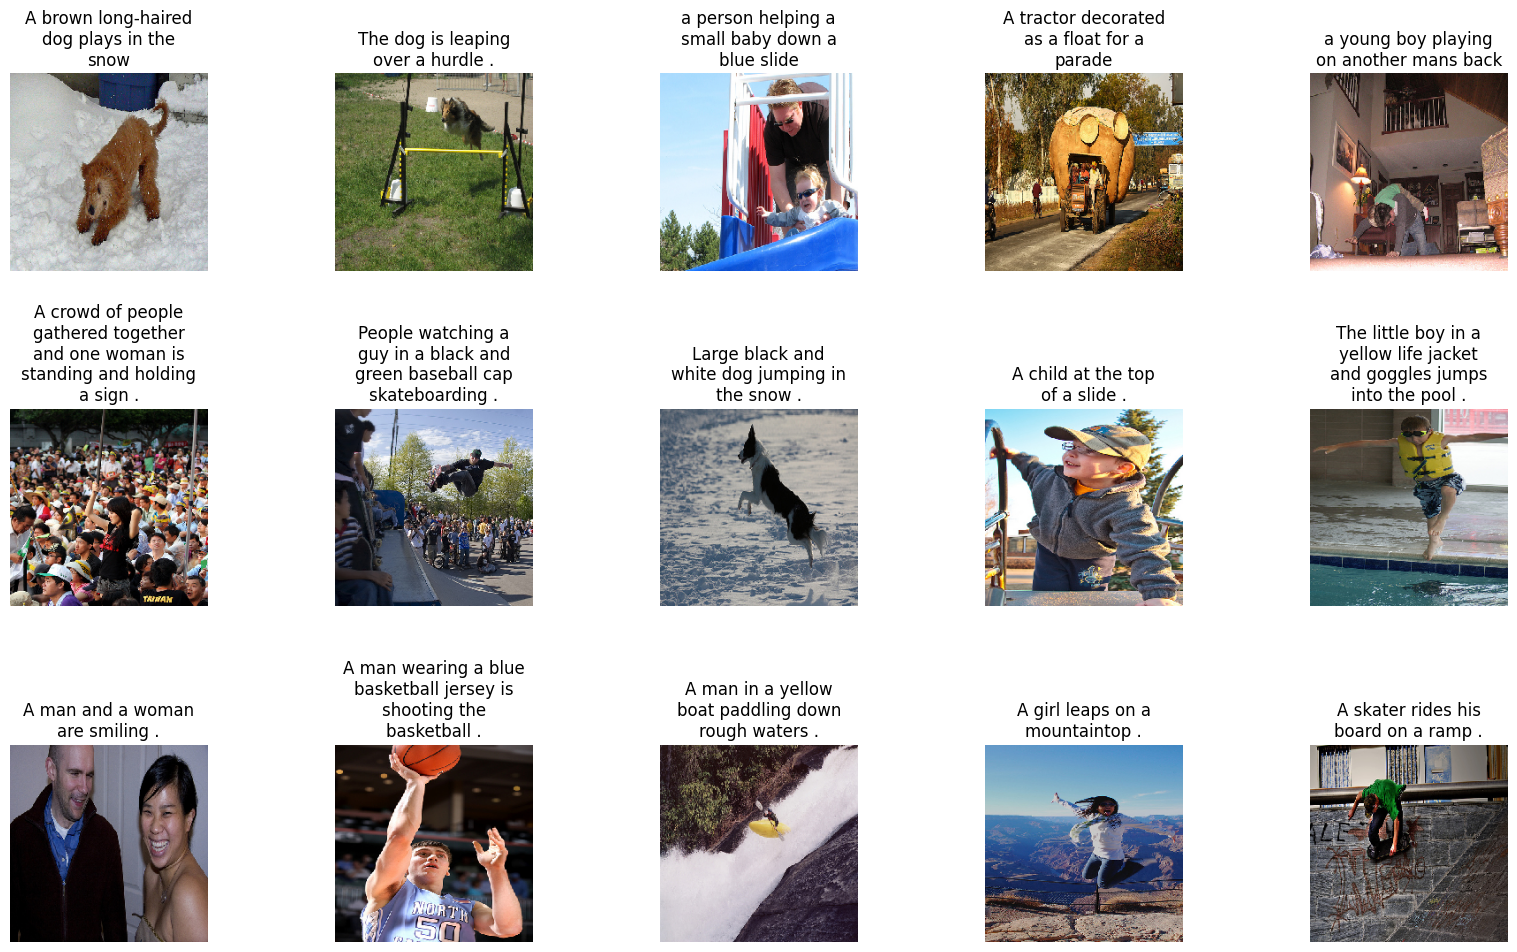

In [ ]:
display_images(data.sample(15))


In [ ]:
Base_dir="flicker"
working_dir="WORKING"

# **Features Extraction**

In [ ]:
#load vgg16 model
model= VGG16()
#restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
#summarize
print(model.summary())

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
#Extract Image Feature
features ={}
directory = os.path.join(Base_dir, "Images")

for img_name in tqdm(os.listdir(directory)):
    #load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224,224))
    #convert image pixels to numpy array
    image= img_to_array(image)
    #reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    #preprocess image for vgg
    image=preprocess_input(image)
    #extract feature
    feature = model.predict(image, verbose=0)
    #get image ID
    image_id = img_name.split('.')[0]
    #store feature
    features[image_id] = feature

In [ ]:
#store feature in pickle
pickle.dump(features, open(os.path.join(working_dir,'features.pkl'), 'wb'))

In [ ]:
# load feature from pickle
with open(os.path.join( working_dir ,'features.pkl'),'rb' ) as f:
  features =pickle.load(f)


# **Load the Captions Data**

In [ ]:
with open(os.path.join(Base_dir, 'captions.txt/captions.txt'),'r' ) as f:

  next(f)
  captions_doc = f.read()


In [ ]:
 #create mapping of image to caption
mapping = {}
#process lines
for line in tqdm(captions_doc.split('\n')):
  #split the line by comma(,)
  tokens = line.split(',')
  if len(line) < 2 :
    continue
  image_id, caption = tokens[0], tokens[1:]
  #removing extension fro image ID
  image_id = image_id.split('.')[0]
  #convert caption list to strig
  caption = " ".join(caption)
  # create list if needed
  if image_id not in mapping:
    mapping[image_id]=[]
  #store the caption
  mapping[image_id].append(caption)




  0%|          | 0/40457 [00:00<?, ?it/s]

In [ ]:
len(mapping)

8092

#**preprocessing text data**

In [ ]:
def clean(mapping):
  for key, captions in mapping.items():
    for i in range(len(captions)):
      #take one caption at the time
      caption = captions[i]
      #preprocessing steps
      #convert to lowercase
      caption = caption.lower()
      #remove unneeded digits
      caption = re.sub(r'[^\w\s]', '', caption)
      caption = re.sub(r'\d+', '', caption)
      #delete additional spaces
      caption = re.sub(r'\s+', ' ', caption).strip()

      # Tokenize the text into words
      caption = word_tokenize(caption)

      # Load the English stop words
      stop_words = ['a','an']
      # Filter out the stop words from the text
      caption = [word for word in caption if not word in stop_words]

      #add start and end tag to the caption
      caption = 'startcap ' + ' '.join(caption)+ ' endcap'
      captions[i] = caption

# **Test mapping Func**

In [ ]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
clean(mapping)


In [ ]:
mapping['1000268201_693b08cb0e']


['startcap child in pink dress is climbing up set of stairs in entry way endcap',
 'startcap girl going into wooden building endcap',
 'startcap little girl climbing into wooden playhouse endcap',
 'startcap little girl climbing the stairs to her playhouse endcap',
 'startcap little girl in pink dress going into wooden cabin endcap']

# **continue_text_preprocessing**

In [ ]:
all_captions=[]
for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)

In [ ]:
len(all_captions)

40456

In [ ]:
all_captions[:10]

['startcap child holds palestinian flag endcap',
 'startcap child in pink dress is climbing up set of stairs in entry way endcap',
 'startcap girl going into wooden building endcap',
 'startcap little girl climbing into wooden playhouse endcap',
 'startcap little girl climbing the stairs to her playhouse endcap',
 'startcap little girl in pink dress going into wooden cabin endcap',
 'startcap black dog and spotted dog are fighting endcap',
 'startcap black dog and tricolored dog playing with each other on the road endcap',
 'startcap black dog and white dog with brown spots are staring at each other in the street endcap',
 'startcap two dogs of different breeds looking at each other on the road endcap']

In [ ]:
#tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index)+1

In [ ]:
vocab_size

8778

In [ ]:

# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

33

#**Train Test Split**

In [ ]:
image_ids = list(mapping.keys())
split1 = int(len(image_ids)*0.8)
split2 = int(len(image_ids)*0.9)
train = image_ids[:split1]
val = image_ids[split1:split2]
test = image_ids[split2:]

#**Create Data Generator**

In [ ]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0


# **Model Creation**

In [ ]:
## ENCODER MODEL
#image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2=Dense(256, activation='relu')(fe1)
#sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

## DECODER MODEL
decoder1 = add([fe2, se3])
decoder2= Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy' , optimizer='adam' , metrics=['accuracy'])

#plot the model
plot_model(model, show_shapes=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


![model-2.png](attachment:model-2.png)

In [ ]:

#train the model
epochs = 20
batch_size = 64
steps = len(train) // batch_size

for i in range(epochs):
  #create data generator
     generator_train= data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)

  #fit for one epoch
     model.fit(generator_train, epochs=1, steps_per_epoch=steps, verbose=1)


101/101 [==============================] - 47s 463ms/step - loss: 2.2888 - accuracy: 0.4285


# save the model
model.save(Base_dir+'/bestt_model.h5')


In [ ]:
model = tf.keras.models.load_model(working_dir+'/bestt_model.h5')


# **Generate Captions for the Image**


In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startcap'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endcap':
            break

    return in_text


In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(Base_dir, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)



---------------------Actual---------------------
startcap child in pink dress is climbing up set of stairs in entry way endcap
startcap girl going into wooden building endcap
startcap little girl climbing into wooden playhouse endcap
startcap little girl climbing the stairs to her playhouse endcap
startcap little girl in pink dress going into wooden cabin endcap
--------------------Predicted--------------------
startcap little girl in pink dress is sitting on bench in frosting flowers endcap


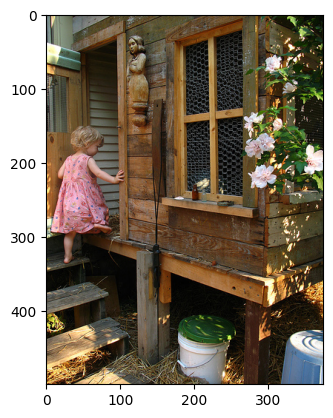

In [ ]:
generate_caption('1000268201_693b08cb0e.jpg')


---------------------Actual---------------------
startcap competitive motorcycle racer prepares to make left turn along paved road endcap
startcap man rides motorcycle with the number on it endcap
startcap motorcycle driver swerves to the left endcap
startcap motorcycle with number five on front is being ridden by rider wearing red helmet endcap
startcap professional motorcycle racer turning corner endcap
--------------------Predicted--------------------
startcap man on motorcycle is turning on the road endcap


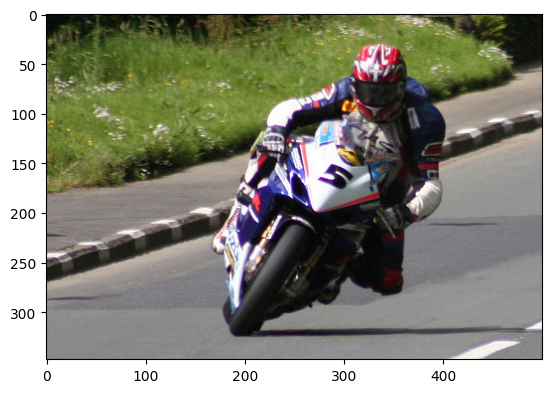

In [ ]:
generate_caption('161669933_3e7d8c7e2c.jpg')


---------------------Actual---------------------
startcap group of five people stand outdoors endcap
startcap five people in back shirts stand in front of small object in grove of trees endcap
startcap five people wearing dark blue shirts give presentation outdoors endcap
startcap four men and one woman in black shirts stand in park endcap
startcap one woman and four men wearing black shirts standing on the grass in the shade endcap
--------------------Predicted--------------------
startcap three men and two men are standing in front of trees endcap


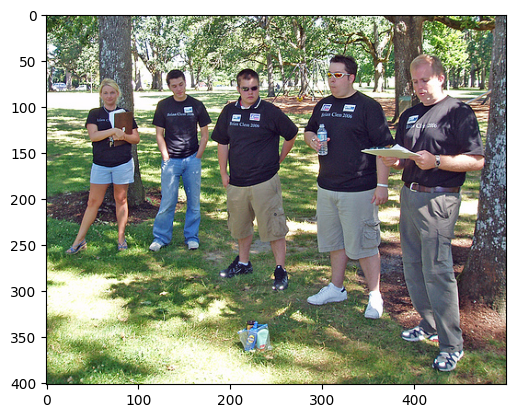

In [ ]:
generate_caption('185057637_e8ada37343.jpg')
